
## MetObs API key (keep private)
2a0bf9fc-ab9c-4616-bb48-21ca990be16f



# Assignment roadmap
- Scope: compare forecast models vs measured GHI for station 06072; compute RMSE & bias per horizon; produce plots and poster-ready figures.
- Data cadence: forecasts hourly/right-binned; measurements 10 min/right-labeled -> resample to hourly.
- Keys: keep everything in UTC; align on forecast issue time + horizon.



## 1) Measurement data (DMI MetObs)
- Download 10-min GHI for station 06072 via API key; basic QC (BSRN min/max).
- Resample to 1h mean (`df.resample('1H', label='right', closed='right').mean()`).
- Save cleaned hourly series for reuse.



### Load hourly measurements
Load resampled station observations (`station_data_hourly.csv`).


In [29]:

obs_path = Path('station_data_hourly.csv')
obs_hourly = pd.read_csv(obs_path, parse_dates=['time'])

print(f'Loaded {len(obs_hourly)} hourly rows from {obs_path}')
display(obs_hourly.head())


Loaded 384 hourly rows from station_data_hourly.csv


,time,ghi
0,2025-11-08 01:00:00+00:00,0.0
1,2025-11-08 02:00:00+00:00,0.0
2,2025-11-08 03:00:00+00:00,0.0
3,2025-11-08 04:00:00+00:00,0.0
4,2025-11-08 05:00:00+00:00,0.0



## 2) Forecast data (open-meteo files)
- Load all `06072_YYYYMMDDT0600.csv` files; parse `date` as datetime (UTC).
- Long-form melt for stacking models; track forecast issue time for horizons.
- Note model horizons differ (e.g., Harmonie ~54h, ECMWF IFS ~10d).



### Setup
Imports and common paths.


In [30]:

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

data_dir = Path("ForcastData")
files = sorted(data_dir.glob("06072_*.csv"))
print(f"Found {len(files)} forecast files in {data_dir}")


Found 11 forecast files in ForcastData



### Load all forecasts and reshape
- Load every `06072_YYYYMMDDT0600.csv` in `ForcastData`.
- Add `issue_time` from filename; compute `horizon_hours = date - issue_time`.
- Melt wide model columns into long `model`/`forecast` for easier grouping and metrics.


In [31]:

from typing import List


def issue_from_name(path: Path) -> pd.Timestamp:
    ts = path.stem.split('_')[1]  # e.g., 20251108T0600
    return pd.to_datetime(ts, format="%Y%m%dT%H%M", utc=True)

frames: List[pd.DataFrame] = []
for f in files:
    issue_time = issue_from_name(f)
    df_tmp = pd.read_csv(f, parse_dates=["date"])
    df_tmp["issue_time"] = issue_time
    df_tmp["horizon_hours"] = (df_tmp["date"] - df_tmp["issue_time"]).dt.total_seconds() / 3600
    long_tmp = df_tmp.melt(
        id_vars=["date", "issue_time", "horizon_hours"],
        var_name="model",
        value_name="forecast"
    )
    long_tmp["source_file"] = f.name
    frames.append(long_tmp)

all_forecasts = pd.concat(frames, ignore_index=True)
print("Loaded rows:", len(all_forecasts))
display(all_forecasts.head())

# Quick check: max horizon per model to understand coverage
max_h = all_forecasts.groupby("model")["horizon_hours"].max().sort_values()
print("\nMax horizon (hours) per model:\n", max_h)


Loaded rows: 14784


,date,issue_time,horizon_hours,model,forecast,source_file
0,2025-11-08 00:00:00+00:00,2025-11-08 06:00:00+00:00,-6.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv
1,2025-11-08 01:00:00+00:00,2025-11-08 06:00:00+00:00,-5.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv
2,2025-11-08 02:00:00+00:00,2025-11-08 06:00:00+00:00,-4.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv
3,2025-11-08 03:00:00+00:00,2025-11-08 06:00:00+00:00,-3.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv
4,2025-11-08 04:00:00+00:00,2025-11-08 06:00:00+00:00,-2.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv



Max horizon (hours) per model:
 model
dmi_harmonie_arome_europe    161.0
dmi_seamless                 161.0
ecmwf_aifs025_single         161.0
ecmwf_ifs                    161.0
ecmwf_ifs025                 161.0
gfs_global                   161.0
gfs_seamless                 161.0
metno_nordic                 161.0
Name: horizon_hours, dtype: float64



### Quick single-file preview & plot
Plot one forecast file to see model shapes.


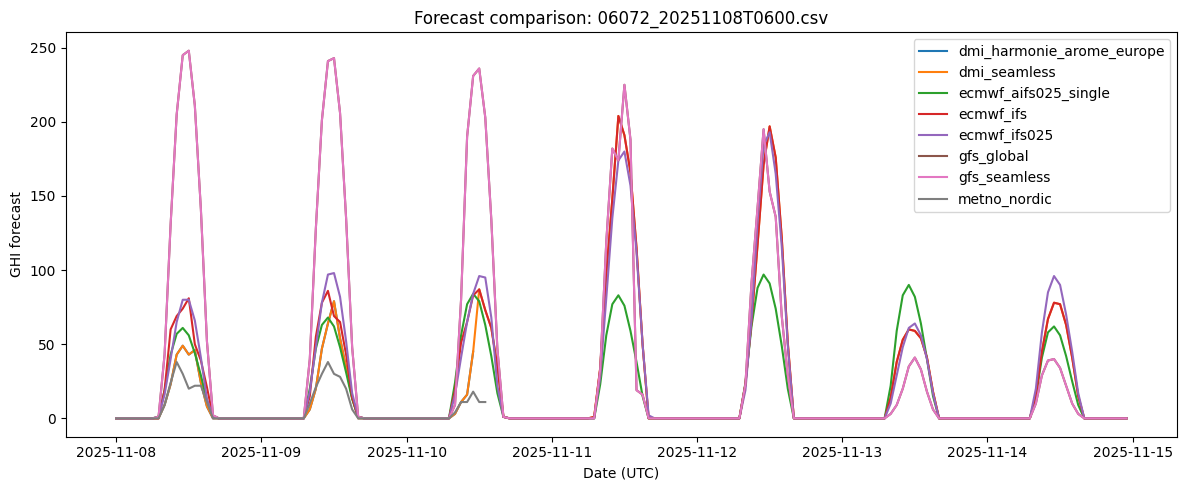

In [32]:

if not files:
    raise ValueError("No forecast files found")

first_file = files[0] # write 0-10 to plot the diffrent files
df_single = pd.read_csv(first_file, parse_dates=["date"])
long_single = df_single.melt(id_vars="date", var_name="model", value_name="forecast")

plt.figure(figsize=(12, 5))
for model, grp in long_single.groupby("model"):
    plt.plot(grp["date"], grp["forecast"], label=model, linewidth=1.5)

plt.xlabel("Date (UTC)")
plt.ylabel("GHI forecast")
plt.title(f"Forecast comparison: {first_file.name}")
plt.legend()
plt.tight_layout()
plt.show()



## 3) Align forecasts vs measurements
- Build forecast horizon `h = date - issue_time` per file; drop negative/NaN.
- Inner-join forecasts with hourly measurements on timestamp.
- Ensure right-edge alignment: forecast hour 02:00 covers 01:01-02:00.



### Align forecasts with measurements
Join forecasts to hourly observations on timestamp and filter valid horizons.


In [33]:

# Prepare observations with a matching timestamp column
obs_ready = obs_hourly.rename(columns={'time': 'date'}).copy()
obs_ready['date'] = pd.to_datetime(obs_ready['date'], utc=True)
obs_ready = obs_ready[['date', 'ghi']]

# Join forecasts with observations on timestamp
aligned = all_forecasts.merge(obs_ready, on='date', how='inner')

# Keep only non-negative horizons and valid values
aligned = aligned[aligned['horizon_hours'] >= 0].dropna(subset=['forecast', 'ghi']).copy()
aligned['error'] = aligned['forecast'] - aligned['ghi']

print(f"Aligned rows: {len(aligned)}")
print(aligned[['model', 'horizon_hours']].groupby('model').size().head())
display(aligned.head())


# Model coverage check
model_counts = aligned.groupby("model").size().sort_values(ascending=False)
print("Rows per model (top 10):", model_counts.head(10))
unique_models = aligned["model"].unique()
print(f"Total models in aligned data: {len(unique_models)} -> {sorted(unique_models)[:5]} ...")


Aligned rows: 11764
model
dmi_harmonie_arome_europe     594
dmi_seamless                 1759
ecmwf_aifs025_single         1759
ecmwf_ifs                    1759
ecmwf_ifs025                 1759
dtype: int64


,date,issue_time,horizon_hours,model,forecast,source_file,ghi,error
5,2025-11-08 06:00:00+00:00,2025-11-08 06:00:00+00:00,0.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv,0.000000,0.000000
6,2025-11-08 07:00:00+00:00,2025-11-08 06:00:00+00:00,1.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv,0.500000,-0.500000
7,2025-11-08 08:00:00+00:00,2025-11-08 06:00:00+00:00,2.0,dmi_harmonie_arome_europe,9.0,06072_20251108T0600.csv,7.000000,2.000000
8,2025-11-08 09:00:00+00:00,2025-11-08 06:00:00+00:00,3.0,dmi_harmonie_arome_europe,23.0,06072_20251108T0600.csv,19.666667,3.333333
9,2025-11-08 10:00:00+00:00,2025-11-08 06:00:00+00:00,4.0,dmi_harmonie_arome_europe,43.0,06072_20251108T0600.csv,29.166667,13.833333


Rows per model (top 10): model
dmi_seamless                 1759
ecmwf_aifs025_single         1759
ecmwf_ifs                    1759
ecmwf_ifs025                 1759
gfs_global                   1759
gfs_seamless                 1759
metno_nordic                  616
dmi_harmonie_arome_europe     594
dtype: int64
Total models in aligned data: 8 -> ['dmi_harmonie_arome_europe', 'dmi_seamless', 'ecmwf_aifs025_single', 'ecmwf_ifs', 'ecmwf_ifs025'] ...



## 4) Exploratory plots
- For a single day: plot measured vs each model to see timing/shape.
- Add scatter of forecast vs measured for a chosen horizon (e.g., 24h).
- Inspect diurnal bias or cloud-related misses.



## 5) Error metrics by horizon
- Compute RMSE and bias per model per horizon across all files.
- Visualize RMSE(h) and bias(h) curves; highlight best-performing model per horizon.
- Summaries: table of RMSE/Bias for 24h, 48h, 72h, etc.



## 6) Blended forecast attempt
- Try weighted blend (e.g., 80/20 or simple average of top models).
- Optimize weights on a validation slice; compare RMSE/Bias vs best single model.
- Keep method simple and reproducible.



## 7) Poster-ready figures & notes
- Key plots: forecast vs measurement (one representative day); RMSE/Bias vs horizon.
- Brief bullets on why certain models perform better; note limitations.
- Include method steps, data sources, and time labels (UTC, right-binned).
